In this notebook we are creating an auto encoder for anomaly detection of time series (here ECG). We are going to use a basic autoencoder , a pytorch variational autoencoder and a pyro variational auto encoder.

The dataset is composed of a list of heartbeat from a single patient (http://timeseriesclassification.com/description.php?Dataset=ECG5000), some being labelled normal and some other being labeled abnormal. We are going to train an autoencoder on normal heartbeat so we can find a lower dimensional representation of the normal heartbeat ecg recording. On that lower dimensional representation it will be easier to spot abnormal heartbeat as they should stand in some very different place on that latent space compare to the normal heartbeat, and the model should have a harder time to represent them. So by choosing a threshold on what we consider a good representation or not we should be able to identify heartbeat that doesn't ressemble normal heartbeat. 

The data are timeseries so the encoder and decoders will be made of LSTM.

The data set, a part of of the data preprocessing and the simple autoencoder part is highly inspired from https://curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/ (I changed the loss function and I made it working with batch, I also modified some transformation of the data shape that for me is clearer and hopefully more robust). The variational autoencoder with pytorch is highly inspired by , and the pyro autoencoder by https://pyro.ai/examples/vae.html

### The goal here is not ot present what is behind an autoencoder. 

A great article to understand the concepts of an AE is https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73. I highly highly recomend you go take a look before going through this pile of code.

I always thought that the way the different loss function are brought is not really straightforward. A better understanding for me of those loss function can be found as forum answers from : https://stats.stackexchange.com/questions/304289/variational-autoencoder-understanding-the-latent-loss and https://stats.stackexchange.com/questions/304146/explanation-needed-for-vae-latence-space-cost-term/305610#305610. Finally there is a bit of discussion with using the MSE in the variational loss. I found this useful : https://arxiv.org/pdf/2006.10273.pdf

# Preprocessing

In [1]:
from arff2pandas import a2p#you will need that for the reading of the ecg format file
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
import copy

In [2]:
import torch#; torch.manual_seed(42)

import torch.nn.functional as F
import torch.utils
import torch.distributions

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
with open('ECG5000/ECG5000_TRAIN.arff') as f:
    train = a2p.load(f)
with open('ECG5000/ECG5000_TEST.arff') as f:
    test = a2p.load(f)

In [5]:
df = train.append(test)
df = df.sample(frac=1.0)
df.shape

CLASS_NORMAL = 1
class_names = ['Normal','R on T','PVC','SP','UB']

new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

In [6]:
df.target.value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

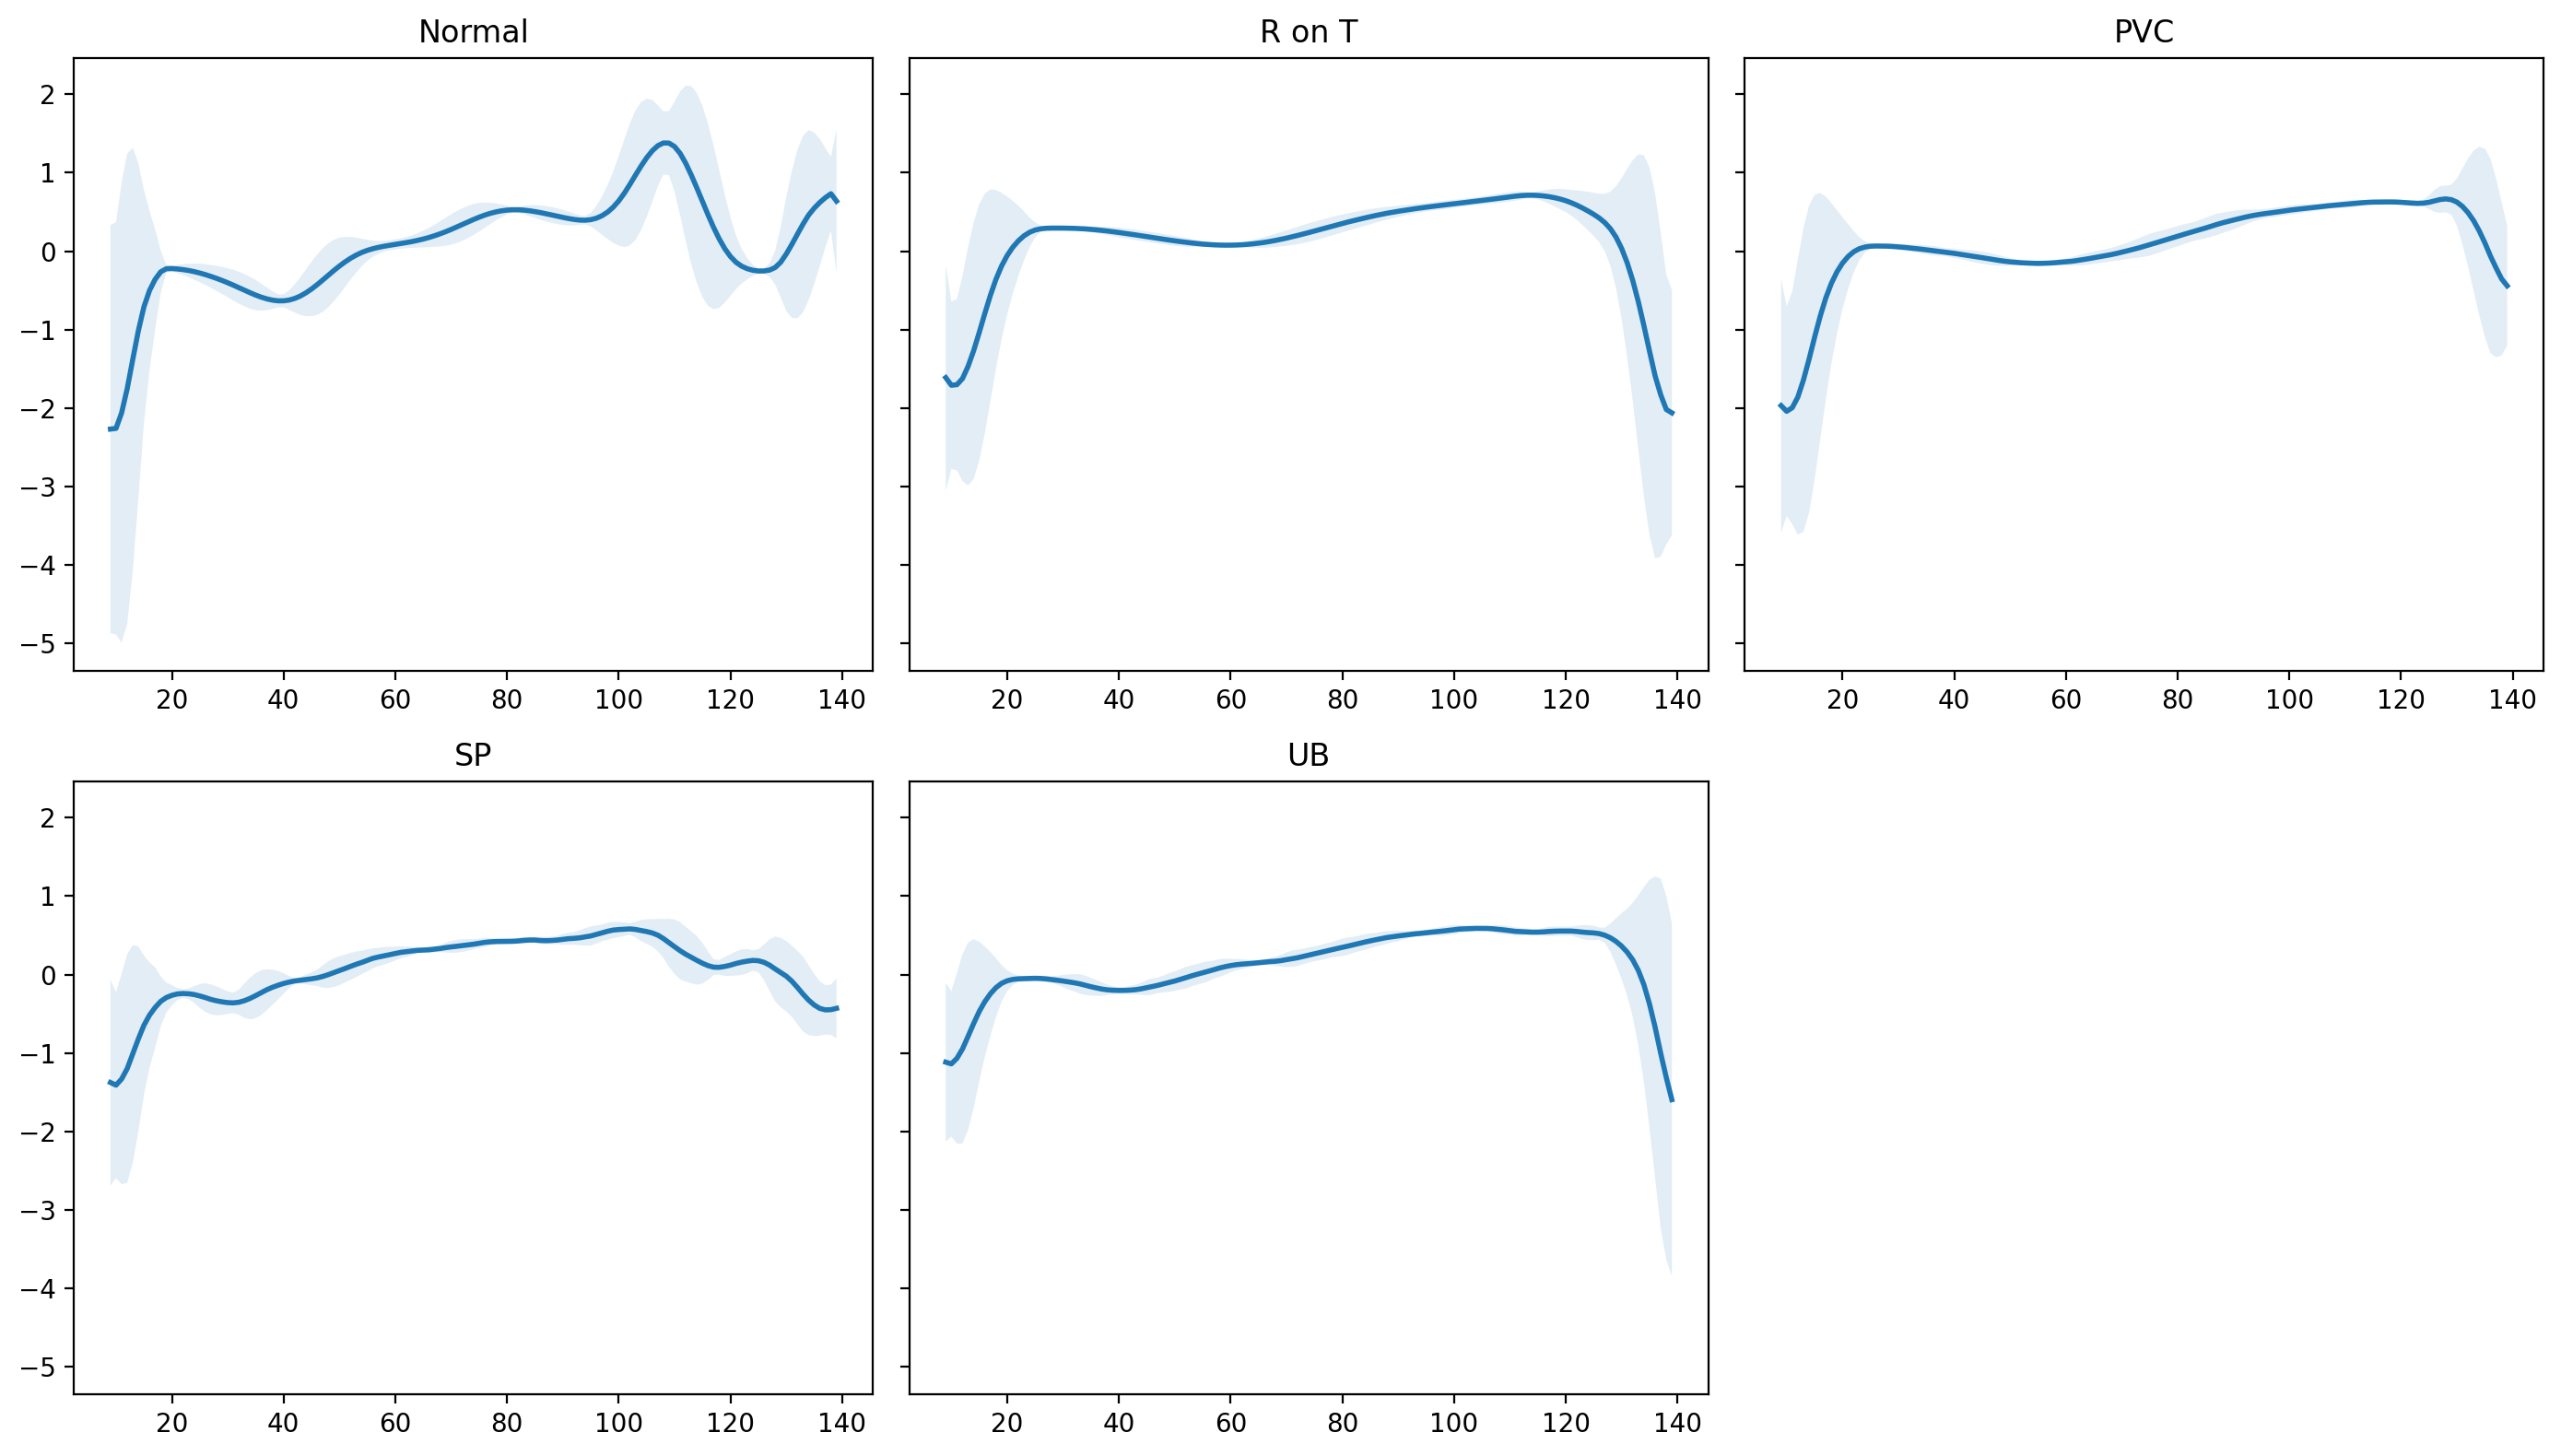

In [7]:
#this is 100% from  https://curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/
def plot_time_series_class(data, class_name, ax, n_steps=10):
    time_series_df = pd.DataFrame(data)

    smooth_path = time_series_df.rolling(n_steps).mean()
    path_deviation = 2 * time_series_df.rolling(n_steps).std()

    under_line = (smooth_path - path_deviation)[0]
    over_line = (smooth_path + path_deviation)[0]

    ax.plot(smooth_path, linewidth=2)
    ax.fill_between(
        path_deviation.index,
        under_line,
        over_line,
        alpha=.125
    )
    ax.set_title(class_name)
    
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
    ax = axs.flat[i]
    data = df[df.target == cls] \
        .drop(labels='target', axis=1) \
        .mean(axis=0) \
        .to_numpy()
    plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();


In [8]:
normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

In [9]:
anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

In [10]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=42
)
val_df, test_df = train_test_split(
  val_df,
  test_size=0.33,
  random_state=42
)


In [11]:
def create_dataset(df):
    sequences = df.astype(np.float32).to_numpy().tolist()
    dataset = [torch.tensor(s).unsqueeze(1).numpy() for s in sequences]
    n_seq, seq_len, n_features = np.stack(dataset).shape
    return dataset, seq_len, n_features

In [12]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [13]:
from torch.utils.data import Dataset
class ECG_dataset(Dataset):
    def __init__(self,sequences,targets):
        self.sequences=sequences
        self.targets=targets
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, item):
        sequence=self.sequences[item]
        target=int(self.targets[item])
        return {'sequence': torch.tensor(sequence, dtype=torch.float32),
                'target': torch.tensor(target, dtype=torch.long)
               }

In [14]:

i_train_dataset = ECG_dataset(sequences=train_dataset,targets=[0 for i in range(len(train_dataset))])

i_train_data_loader = torch.utils.data.DataLoader(i_train_dataset,batch_size=128,num_workers=16)

i_val_dataset = ECG_dataset(sequences=val_dataset,targets=[0 for i in range(len(val_dataset))])

i_val_data_loader = torch.utils.data.DataLoader(i_val_dataset,batch_size=128,num_workers=16)

# Pytorch AE

![AE](AE.png)

source : https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73

In [15]:
class EncoderAE(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(EncoderAE, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
        )
    def forward(self, x):
        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)
        #by using hidden_n I am restraining myself to the last hidden state of the time serie, whereas x is the
        #time serie of hidden states. The last hidden state is what we want because we want the latent space
        #representation where a time serie is just a point in this space not a time serie of point anymore.
        return hidden_n.permute(1,0,2)#we need to permute the hidden so it has the right form to feed an LSTM.
    # Check the documentation to see why, it is pretty simple

In [16]:
class DecoderAE(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(DecoderAE, self).__init__()
        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features
        self.rnn1 = nn.LSTM(
            input_size=self.input_dim,
          hidden_size=self.input_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
            input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.output_layer = nn.Linear(self.hidden_dim, n_features)
    def forward(self, x):#x is a tensor of single point representing a time serie in a latent space,
        #but rnn need a time serie, so we use repeat to create a serie of those repeated single point
        x = torch.stack([x1.repeat(self.seq_len, self.n_features)for x1 in x])
        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        return self.output_layer(x)

In [17]:
class RecurrentAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()
        self.encoder = EncoderAE(seq_len, n_features, embedding_dim).to(device)
        self.decoder = DecoderAE(seq_len, embedding_dim, n_features).to(device)
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

/home/seb/anaconda3/envs/base_py39/lib/python3.9/site-packages/torch/backends/cudnn/__init__.py:73: UserWarning: PyTorch was compiled without cuDNN/MIOpen support. To use cuDNN/MIOpen, rebuild PyTorch making sure the library is visible to the build system.
  warnings.warn(


In [19]:
def train_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    #criterion = nn.L1Loss(reduction='mean').to(device)# You just want to minimize the distance between ground truth
    # and encoded-small dimensionality space-decoded(ground truth). To me at least the L2 loss makes more sense.
    # Indeed later on, using the variational principle with an assumption on the Gaussian form of the decoder
    # the L2 loss appears by itself, rescaled by a factor which is the variance of the decoder and shifted
    # by an amouint equal to the log of that variance... But ok.
    criterion = nn.MSELoss(reduction='mean').to(device)
    history = dict(train=[], val=[])
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
    for epoch in range(1, n_epochs + 1):
        model = model.train()
        train_losses = []
        for d in train_dataset:
            seq_true=d['sequence']
            optimizer.zero_grad()
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)
            loss = criterion(seq_pred, seq_true)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for d in val_dataset:
                seq_true=d['sequence']
                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)
                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        history['train'].append(train_loss)
        history['val'].append(val_loss)
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
    model.load_state_dict(best_model_wts)
    return model.eval(), history

In [20]:
model, history = train_model(
  model,
  i_train_data_loader,
  i_val_data_loader,
  n_epochs=500
)

Epoch 1: train loss 0.9222135514020919 val loss 0.8420993288358053
Epoch 2: train loss 0.6922070354223251 val loss 0.5846636891365051
Epoch 3: train loss 0.4968719869852066 val loss 0.46305657426516217
Epoch 4: train loss 0.42564956843852997 val loss 0.41672924160957336
Epoch 5: train loss 0.3812735199928284 val loss 0.35091163714726764
Epoch 6: train loss 0.3575488418340683 val loss 0.3384915590286255
Epoch 7: train loss 0.35353922843933105 val loss 0.33691848317782086
Epoch 8: train loss 0.35014028698205946 val loss 0.33246665199597675
Epoch 10: train loss 0.348892742395401 val loss 0.33150344093640643
Epoch 11: train loss 0.3319142505526543 val loss 0.31730104486147565
Epoch 14: train loss 0.31718404293060304 val loss 0.3094737231731415
Epoch 15: train loss 0.30874502658843994 val loss 0.30822426080703735
Epoch 16: train loss 0.30303056836128234 val loss 0.2989397545655568
Epoch 18: train loss 0.29762893319129946 val loss 0.2972377836704254
Epoch 20: train loss 0.301302881538868 val

In [21]:
def loss_plot(loss_train,loss_val):
    fig=plt.figure(figsize=(5,5))
    plt.plot(np.arange(len(loss_train)),loss_train,'b',label='train')
    plt.plot(np.arange(len(loss_val)),loss_val,'r',label='val')
    plt.legend(loc='best')
    plt.xlabel('epochs')
    #plt.ylabel('L1 loss')
    plt.ylabel('MSE loss')
    plt.show()

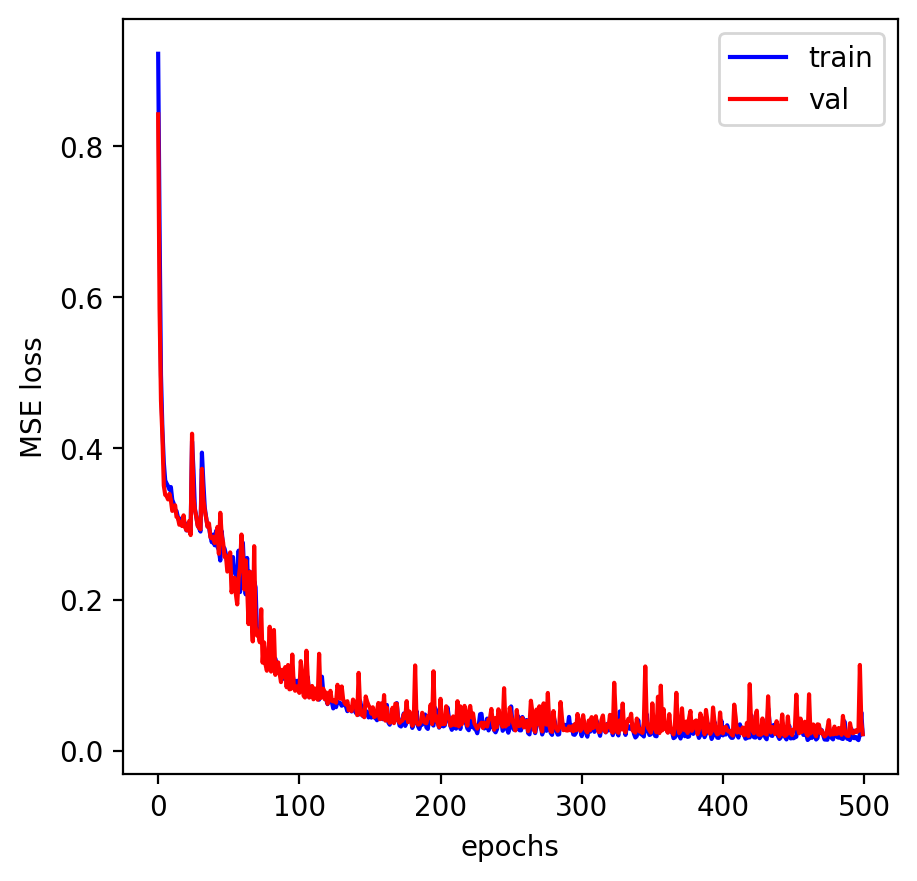

In [22]:
loss_plot(history['train'],history['val'])

In [23]:
MODEL_PATH = 'model_AE_ECG_epochs_500_latentdim_128_l2.pth'
torch.save(model.state_dict(), MODEL_PATH)

In [24]:
#just concatenate everything: train val,test, abnormal ,normal
df_n_a=pd.concat([normal_df,anomaly_df])
df_n_a

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,...,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC
1844,0.622861,-0.907801,-2.458567,-3.792110,-4.239413,-3.579284,-2.364286,-1.730298,-1.546048,-0.835706,...,1.046461,1.206656,1.086298,1.202142,1.196530,0.910479,0.844012,1.131866,1.340387,-0.172942
2415,-1.292827,-2.794414,-3.051036,-3.490047,-3.271823,-2.981993,-2.249117,-1.734051,-1.619068,-1.278633,...,1.739602,1.679748,1.351740,0.839831,0.232754,0.034892,0.077635,0.343289,0.694948,0.085806
293,1.285556,-0.569614,-2.510118,-3.390062,-4.449366,-4.088810,-2.576052,-1.660459,-1.430484,-0.416571,...,-0.314519,0.213685,1.436396,1.673820,1.429045,1.600360,1.262255,0.598493,-0.628014,-0.928534
1976,2.188824,0.170222,-2.065495,-3.227307,-4.217942,-3.946608,-2.730205,-1.812108,-1.732260,-0.859740,...,-0.513538,-0.531080,0.098905,0.457758,0.681999,1.234673,1.310166,1.580161,1.087480,1.209402
1864,0.111600,-2.546138,-3.604936,-4.253965,-4.351769,-3.267472,-2.097801,-1.762223,-1.248807,-0.386953,...,1.169889,1.619184,1.633680,1.558988,1.188391,0.510549,0.237538,0.539764,1.056044,-1.696393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4192,0.455302,-0.400660,-1.305552,-1.775596,-2.126021,-2.314018,-2.216379,-1.795778,-1.209528,-0.660280,...,-0.897311,-1.290767,-1.806019,-2.419160,-2.932126,-4.036368,-4.750278,-4.107091,-2.851758,-2.016979
2746,-0.885042,-2.175073,-2.801528,-3.422596,-3.531922,-3.307601,-3.123791,-2.676292,-1.690222,-0.943466,...,-0.561596,-1.159557,-1.671854,-1.997448,-2.779863,-3.304028,-3.058201,-1.993219,-0.689876,0.562038
3689,-0.052029,-1.166668,-1.760398,-2.468790,-2.846996,-3.081430,-2.920062,-2.597700,-2.206110,-1.547013,...,-2.056779,-2.544778,-3.215986,-3.650375,-3.411444,-2.814130,-1.826358,-0.689839,-0.515141,0.438252
458,0.948182,1.138451,1.592974,1.423006,1.014557,0.484283,-0.036758,-0.387983,-0.650710,-0.949331,...,-2.194626,-3.023802,-3.576255,-3.957947,-4.243667,-4.330395,-3.743970,-2.368827,-1.692377,-0.369056


In [25]:
_dataset, _, _ = create_dataset(df_n_a)
i_dataset = ECG_dataset(sequences=_dataset,targets=[0 for i in range(len(normal_df))]+[1 for i in range(len(anomaly_df))])

i_data_loader = torch.utils.data.DataLoader(i_dataset,batch_size=128,num_workers=16)

In [26]:
import umap.umap_ as umap

def plot_latent_ea(autoencoder, data,nei):
    stack=[]
    stacky=[]
    for i, d in enumerate(data):
        x=d['sequence']
        y=d['target'].to('cpu').detach().numpy().tolist()
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        stack.extend([x[0] for x in z])
        stacky.extend(y)
    
    umaper = umap.UMAP(n_components=2,n_neighbors=nei)
    x_umap = umaper.fit_transform(stack)
    sc=plt.scatter(x_umap[:, 0], x_umap[:, 1],s=2, c=stacky, cmap='RdBu')
    cb = plt.colorbar(sc,ticks=np.arange(0,2,1))
    cb.ax.tick_params(labelsize=9)
    cb.ax.set_yticklabels(['Normal','Abnormal'])
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.show()
            

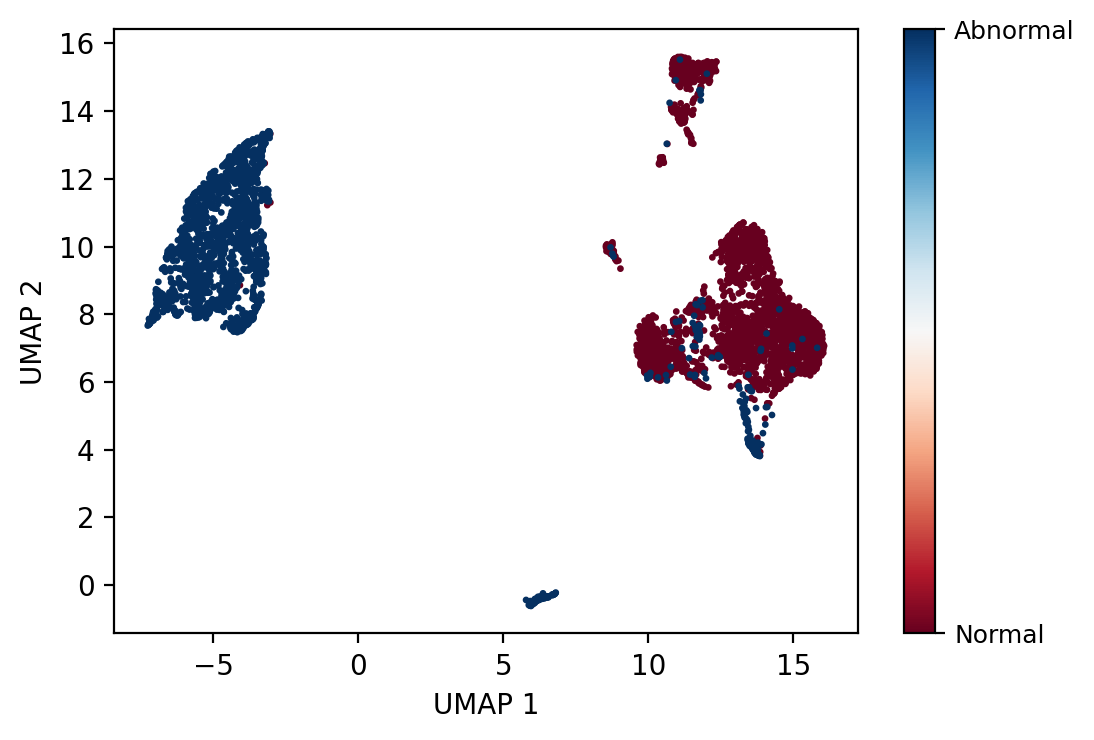

In [27]:
plot_latent_ea(model, i_data_loader,100)

The main part of the abnormal ECG seats away from the normal  ecg in the latent space! So from there we could either use our arsenal of classification technics if we have enought and comparable numbers of abnormal vs normal. We could also check the loss function output and put a threshold on that L1 loss : indeed the abnormal ecg should have a higher loss than normal ecg since the model has never seen them and is train to fit a subclass of ecg from which the abormal are not part. This is to me the best thing to do when your anomalies are rare and you can not use usual technics : by doing so you just set what you think is good enought as a false positive rate.

In some publication I have seen people use one class SVM to draw the countours of the non anomaly point. It is also a good option since it is unsupervised and thus would work nicely in the case where you don't have access to rare event anomaly. The problem is that you will have to deal with quite a few hyper parameters but you don't have a validation (or even a training by the way) set to use (if you had you would be using classification technics). So you could instead choose the hyper parameters in relation to the false positive rate too...

I 'll try some of those options another day.

# Pytorch VAE

Here in the loss function there is a trade off between the reconstruction loss which for a gaussian decoder is similar to the MSE and the KL divergence due to our encoder approximation matching to a noarmal distribution. The reconstruction loss is almost the MSE but scaled by the variance of the decoder and shifted by the log of that variance (A Tutorial on VAEs: From Bayes’ Rule to Lossless Compression : Ronald Yu). How to infer this variance is problematic (unless you use Pyro which is fully Bayesian and so do not use MSE and infer the variance), so here I estimate this variance by estimating the variance on the decoded batch (model.self.C). Honestly I am not too confident that this is the actual way to do it... But as you can see it is not too bad (way better than using the simple MSE : try it)

![AE](bigVAE.png)

source : https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73
        
Somehow the loss function is missing the log variance shift introduced in     https://arxiv.org/pdf/2006.10273.pdf    

In [28]:
class EncoderVAE(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(EncoderVAE, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
        
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
        )
        self.rnn3 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
        )
    def forward(self, x):
        
        x, (_, _) = self.rnn1(x)
        x1, (hidden_n_mu, _) = self.rnn2(x)
        x2, (hidden_n_sigma, _) = self.rnn3(x)
        og_mu=hidden_n_mu.permute(1,0,2)
        og_sigma=torch.exp(hidden_n_sigma.permute(1,0,2))
        
        z = og_mu + og_sigma*self.N.sample(og_mu.shape)#reparametrization trick
        self.kl = (og_sigma**2 + og_mu**2 - torch.log(og_sigma) - 1/2).mean()#analytical solution for the 
        #KL divergence between a gaussian distributed aproximate encoder and the prior distribution of our latent
        #variable that we set to be normal.
        return z
    
    
    
class DecoderVAE(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(DecoderVAE, self).__init__()
        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features
        self.C = 0
        self.rnn1 = nn.LSTM(
            input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
            input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.output_layer = nn.Linear(self.hidden_dim, n_features)
    def forward(self, x):
        x = torch.stack([x1.repeat(self.seq_len, self.n_features)for x1 in x])
        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        out = self.output_layer(x)
        temp = out.std(axis=0)**2
        self.C = temp.mean()
        return out    

In [29]:
class RecurrentVariationalAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentVariationalAutoencoder, self).__init__()
        self.encoder = EncoderVAE(seq_len, n_features, embedding_dim).to(device)
        self.decoder = DecoderVAE(seq_len, embedding_dim, n_features).to(device)
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [30]:
variational_model = RecurrentVariationalAutoencoder(seq_len, n_features, 128)
variational_model = variational_model.to(device)

/home/seb/anaconda3/envs/base_py39/lib/python3.9/site-packages/torch/backends/cudnn/__init__.py:73: UserWarning: PyTorch was compiled without cuDNN/MIOpen support. To use cuDNN/MIOpen, rebuild PyTorch making sure the library is visible to the build system.
  warnings.warn(


In [31]:
def train_variational_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    #criterion = nn.L1Loss(reduction='mean').to(device)#Check L2
    criterion = nn.MSELoss(reduction='mean').to(device)
    history = dict(train=[], val=[])
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
    for epoch in range(1, n_epochs + 1):
        model = model.train()
        train_losses = []
        for d in train_dataset:
            seq_true=d['sequence']
            optimizer.zero_grad()
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)
            loss = 0.5*torch.log(2*np.pi*model.decoder.C)+(1./(2*model.decoder.C))*criterion(seq_pred, seq_true)+ model.encoder.kl# ELBO loss : you recognize the l2 loss and the KL divergence
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for d in val_dataset:
                seq_true=d['sequence']
                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)
                loss = 0.5*torch.log(2*np.pi*model.decoder.C)+(1./(2*model.decoder.C))*criterion(seq_pred, seq_true)+ model.encoder.kl
                val_losses.append(loss.item())
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        history['train'].append(train_loss)
        history['val'].append(val_loss)
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
    model.load_state_dict(best_model_wts)
    return model.eval(), history

In [32]:
variational_model, variational_history = train_variational_model(
  variational_model,
  i_train_data_loader,
  i_val_data_loader,
  n_epochs=500
)

Epoch 1: train loss 79.58963621854782 val loss 2.6665499210357666
Epoch 2: train loss 2.4980324506759644 val loss 2.4745803674062095
Epoch 3: train loss 2.474575090408325 val loss 2.459425926208496
Epoch 4: train loss 2.449224317073822 val loss 2.441295623779297
Epoch 5: train loss 2.43380982875824 val loss 2.4225501219431558
Epoch 7: train loss 2.415902149677277 val loss 2.413698673248291
Epoch 8: train loss 2.4095627665519714 val loss 2.4032695293426514
Epoch 9: train loss 2.402864193916321 val loss 2.3922269344329834
Epoch 10: train loss 2.400283169746399 val loss 2.387815316518148
Epoch 11: train loss 2.3781270146369935 val loss 2.37497345606486
Epoch 12: train loss 2.3440464615821837 val loss 2.314317067464193
Epoch 13: train loss 2.295629072189331 val loss 2.2810251712799072
Epoch 14: train loss 2.2701217889785767 val loss 2.2640719413757324
Epoch 16: train loss 2.252166748046875 val loss 2.238389809926351
Epoch 18: train loss 2.237150275707245 val loss 2.2318338553110757
Epoch 2

Epoch 450: train loss 0.4811735823750496 val loss 0.4702669481436412
Epoch 453: train loss 0.47625418901443484 val loss 0.46241770188013714
Epoch 476: train loss 0.46058664470911026 val loss 0.45135388771692914


In [33]:
def loss_plot_torch_vae(loss_train,loss_val):
    fig=plt.figure(figsize=(5,5))
    plt.plot(np.arange(len(loss_train)),loss_train,'b',label='train')
    plt.plot(np.arange(len(loss_val)),loss_val,'r',label='val')
    plt.legend(loc='best')
    plt.xlabel('epochs')
    #plt.ylabel('L1 loss')
    plt.ylabel('Homemade loss ~ ELBO like')
    plt.show()

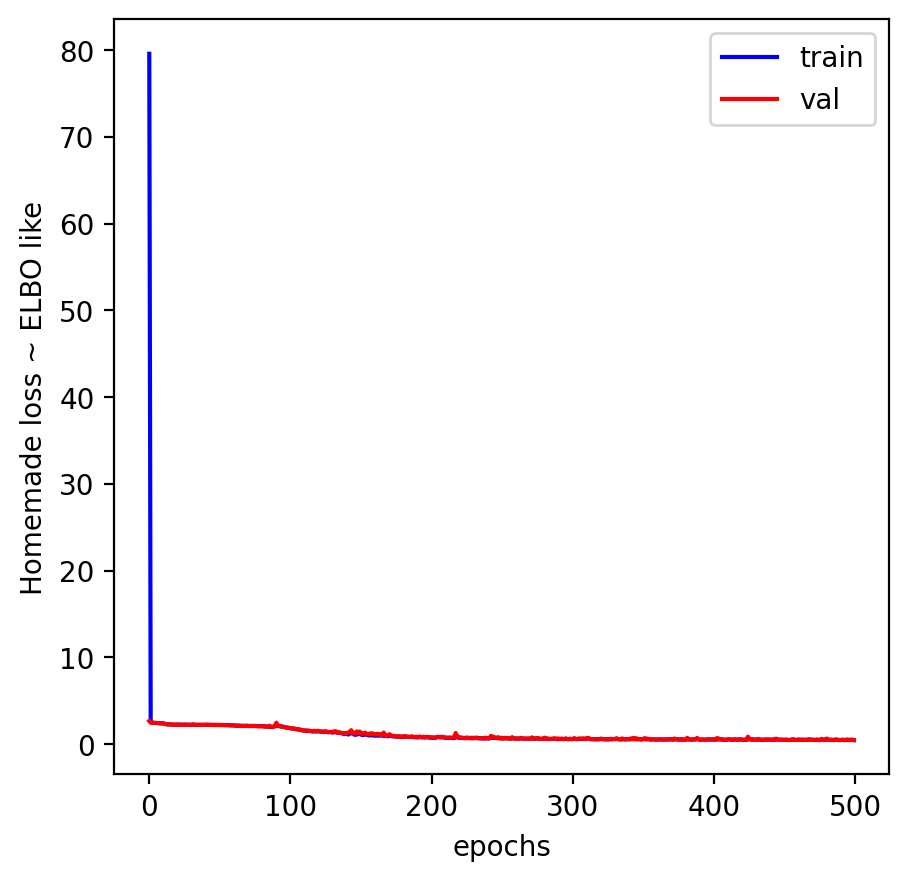

In [34]:
loss_plot_torch_vae(variational_history['train'],variational_history['val'])

In [35]:
MODEL_PATH = 'model_VAE_ECG_epochs_500_latentdim_128_l2.pth'
torch.save(variational_model.state_dict(), MODEL_PATH)

In [36]:
def plot_latent_vea(autoencoder, data,nei):
    stack=[]
    stacky=[]
    for i, d in enumerate(data):
        x=d['sequence']
        y=d['target'].to('cpu').detach().numpy().tolist()
        kee=[]
        for k in range(100):#the econder is stochastic so we draw 100 time to calculate/ represent the mean
            z = autoencoder.encoder(x.to(device))
            z = z.to('cpu').detach().numpy()
            kee.append([r[0] for r in z])
        kee=np.array(kee)
        z = kee.mean(axis=0).tolist()
        stack.extend(z)
        stacky.extend(y)
    
    umaper = umap.UMAP(n_components=2,n_neighbors=nei)
    x_umap = umaper.fit_transform(stack)
    sc=plt.scatter(x_umap[:, 0], x_umap[:, 1],s=2, c=stacky, cmap='RdBu')
    cb = plt.colorbar(sc,ticks=np.arange(0,2,1))
    cb.ax.tick_params(labelsize=9)
    cb.ax.set_yticklabels(['Normal','Abnormal'])
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.show()

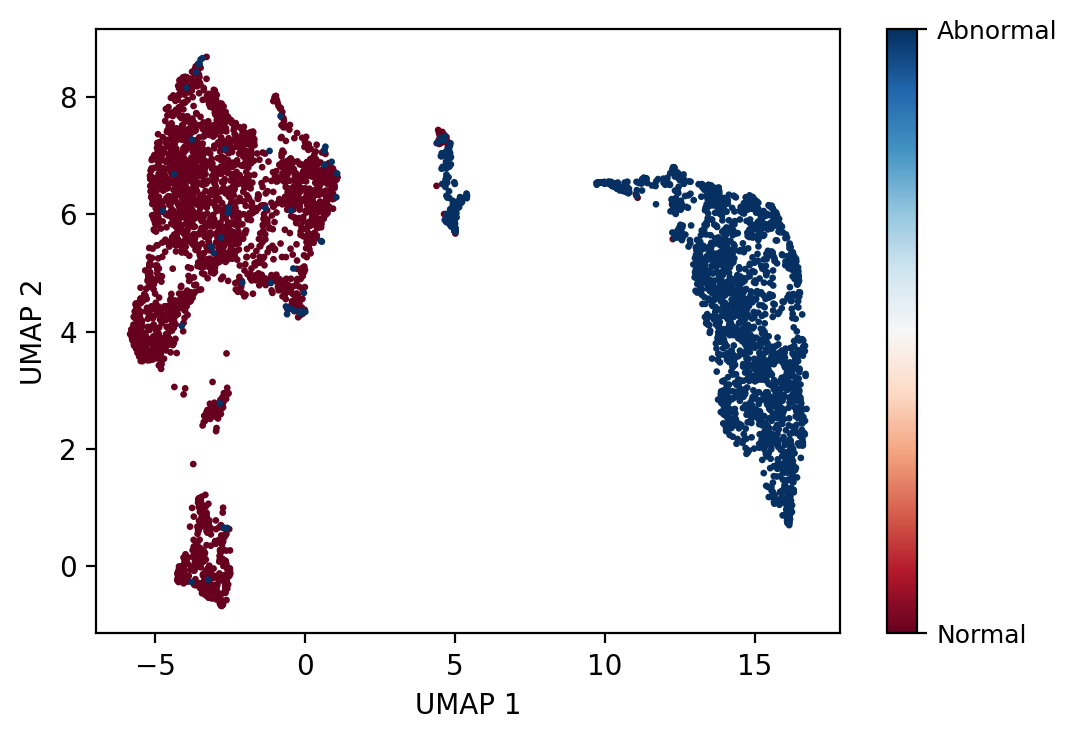

In [37]:
plot_latent_vea(variational_model, i_data_loader,100)

Not too bad for a homemade loss function....

In [38]:
variational_model.decoder.C

tensor(0.0647, device='cuda:0')

# Pyro VAE

With Pyro it is the same architecture than the VAE before but the loss function is the true ELBO (not some chimer using MSE), and the way it is solved is by variational inference. So this is for me the most Kasher way to do it.

In [39]:
import pyro
import pyro.distributions as dist

from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

from torch.distributions import constraints

In [40]:
class EncoderPyroVAE(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(EncoderPyroVAE, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
        
        
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
        )
        self.rnn3 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
        )
    def forward(self, x):
        x, (_, _) = self.rnn1(x)
        x1, (hidden_n_mu, _) = self.rnn2(x)
        x2, (hidden_n_sigma, _) = self.rnn3(x)

        z_loc=hidden_n_mu.permute(1,0,2)
        z_scale=torch.exp(hidden_n_sigma.permute(1,0,2))
        
        
        return z_loc.squeeze(),z_scale.squeeze()#I need to squeeze to get rid to the extra dimension of my data.
    #This extra dimension is linked to how our x is defined : each point in x as a single feature. This
    #dimension is dragued till this end but pyro doesn't get it so I had to squeeze.
    
    
    
class DecoderPyroVAE(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(DecoderPyroVAE, self).__init__()
        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features
        self.rnn1 = nn.LSTM(
            input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
            input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.output_layer = nn.Linear(self.hidden_dim, n_features)
    def forward(self, x):
        x = torch.stack([x1.repeat(self.seq_len, self.n_features)for x1 in x])
        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = self.output_layer(x)
        return x

    


        
class PyroVAE(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64,use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = EncoderPyroVAE(seq_len, n_features, embedding_dim)
        self.decoder = DecoderPyroVAE(seq_len, embedding_dim, n_features)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = embedding_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        #sigma = pyro.sample("sigma",dist.HalfCauchy(0.1))
        sigma = pyro.param("sigma", torch.tensor([0.4]), constraint=constraints.positive)
        # we are going to fit our data with a normal distribution (very approximate here...)
        #(see that as the maxlieklihood part of our loss : before we were using L1 or L2 now
        # since we are using distribution we use maxlikelihood)
        # that will be centered around the output of our decoder on a specific region of the latent space
        # that will be sampled according of the encoder results... The sigma of that normal distribution
        # if found to maximize likelihood
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0],self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0],self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            loc_ecg = self.decoder(z)
            
            # score against actual ecg (log likelihood)
            pyro.sample("obs", dist.Normal(loc_ecg.squeeze(),sigma.to(device)).to_event(1), obs=x.squeeze())


    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
    # we will need a reconstruct to actually check how our algo generalize
    # Indeed we can not evaluate the ELBO loss on a validation test.... SO we are going to use L1 or 2
    def reconstruct_ecg(self, x):
        # encode ecg x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the ecg
        loc_ecg = self.decoder(z)
        return loc_ecg

In [41]:
def train_pyroVAE_better(svi, model,train_loader,val_loader, use_cuda=False):
    # initialize loss accumulator
    #criterion = nn.L1Loss(reduction='mean').to(device)#Check L2
    criterion = nn.MSELoss(reduction='mean').to(device)
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for d in train_loader:
        # if on GPU put mini-batch into CUDA memory
        x=d['sequence']
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)
    val_losses = []
    train_losses = []
    #not sure you need any of those eval and torch.no_grad(). Let's check the l1 loss for our training and eval
    model = model.eval()
    with torch.no_grad():
        for d in train_loader:
            seq_true=d['sequence']
            seq_true = seq_true.to(device)
            seq_pred = model.reconstruct_ecg(seq_true)
            loss = criterion(seq_pred, seq_true)
            train_losses.append(loss.item())
        for d in val_loader:
            seq_true=d['sequence']
            seq_true = seq_true.to(device)
            seq_pred = model.reconstruct_ecg(seq_true)
            loss = criterion(seq_pred, seq_true)
            val_losses.append(loss.item())
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train,train_loss,val_loss

In [42]:
LEARNING_RATE = 1.0e-3
USE_CUDA = True

# Run only for a single iteration for testing
NUM_EPOCHS = 500


pyro.clear_param_store()

# setup the VAE
pyrovae = PyroVAE(seq_len, n_features, 128,use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(pyrovae.model, pyrovae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
val_l1_list = []
train_l1_list = []
pyro.clear_param_store()
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train,train_l1,val_l1 = train_pyroVAE_better(svi, pyrovae,i_train_data_loader,i_val_data_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    train_l1_list.append(train_l1)
    val_l1_list.append(val_l1)
    print("[epoch %03d]  average training ELBO loss: %.4f, average training l1 loss: %.4f average val loss: %.4f" % (epoch, total_epoch_loss_train,train_l1,val_l1))

/home/seb/anaconda3/envs/base_py39/lib/python3.9/site-packages/torch/backends/cudnn/__init__.py:73: UserWarning: PyTorch was compiled without cuDNN/MIOpen support. To use cuDNN/MIOpen, rebuild PyTorch making sure the library is visible to the build system.
  warnings.warn(


[epoch 000]  average training ELBO loss: 409.1551, average training l1 loss: 0.8289 average val loss: 0.8273
[epoch 001]  average training ELBO loss: 265.7294, average training l1 loss: 0.4996 average val loss: 0.4975
[epoch 002]  average training ELBO loss: 216.2306, average training l1 loss: 0.5196 average val loss: 0.5096
[epoch 003]  average training ELBO loss: 183.3928, average training l1 loss: 0.3826 average val loss: 0.3700
[epoch 004]  average training ELBO loss: 156.6962, average training l1 loss: 0.3724 average val loss: 0.3578
[epoch 005]  average training ELBO loss: 152.3520, average training l1 loss: 0.3626 average val loss: 0.3462
[epoch 006]  average training ELBO loss: 149.5040, average training l1 loss: 0.3609 average val loss: 0.3483
[epoch 007]  average training ELBO loss: 147.2876, average training l1 loss: 0.3639 average val loss: 0.3466
[epoch 008]  average training ELBO loss: 145.7654, average training l1 loss: 0.3587 average val loss: 0.3424
[epoch 009]  averag

[epoch 076]  average training ELBO loss: 96.1376, average training l1 loss: 0.2047 average val loss: 0.2060
[epoch 077]  average training ELBO loss: 114.4079, average training l1 loss: 0.3069 average val loss: 0.3077
[epoch 078]  average training ELBO loss: 115.7105, average training l1 loss: 0.2782 average val loss: 0.2802
[epoch 079]  average training ELBO loss: 108.9496, average training l1 loss: 0.2445 average val loss: 0.2476
[epoch 080]  average training ELBO loss: 99.1072, average training l1 loss: 0.2220 average val loss: 0.2193
[epoch 081]  average training ELBO loss: 96.0173, average training l1 loss: 0.2020 average val loss: 0.2024
[epoch 082]  average training ELBO loss: 98.2032, average training l1 loss: 0.2783 average val loss: 0.2816
[epoch 083]  average training ELBO loss: 103.0720, average training l1 loss: 0.2375 average val loss: 0.2352
[epoch 084]  average training ELBO loss: 94.7793, average training l1 loss: 0.2051 average val loss: 0.1986
[epoch 085]  average tra

[epoch 152]  average training ELBO loss: 32.1896, average training l1 loss: 0.0817 average val loss: 0.0840
[epoch 153]  average training ELBO loss: 45.0680, average training l1 loss: 0.0934 average val loss: 0.0907
[epoch 154]  average training ELBO loss: 37.3622, average training l1 loss: 0.0840 average val loss: 0.0851
[epoch 155]  average training ELBO loss: 32.8371, average training l1 loss: 0.0830 average val loss: 0.0857
[epoch 156]  average training ELBO loss: 46.4732, average training l1 loss: 0.0863 average val loss: 0.0890
[epoch 157]  average training ELBO loss: 32.5008, average training l1 loss: 0.0864 average val loss: 0.0892
[epoch 158]  average training ELBO loss: 33.5497, average training l1 loss: 0.0782 average val loss: 0.0803
[epoch 159]  average training ELBO loss: 30.0530, average training l1 loss: 0.0843 average val loss: 0.0866
[epoch 160]  average training ELBO loss: 35.1761, average training l1 loss: 0.0826 average val loss: 0.0827
[epoch 161]  average trainin

[epoch 228]  average training ELBO loss: 14.4462, average training l1 loss: 0.0632 average val loss: 0.0698
[epoch 229]  average training ELBO loss: 13.9348, average training l1 loss: 0.0703 average val loss: 0.0777
[epoch 230]  average training ELBO loss: 8.8103, average training l1 loss: 0.0577 average val loss: 0.0645
[epoch 231]  average training ELBO loss: 6.9813, average training l1 loss: 0.0552 average val loss: 0.0583
[epoch 232]  average training ELBO loss: 6.5660, average training l1 loss: 0.0631 average val loss: 0.0697
[epoch 233]  average training ELBO loss: 19.4964, average training l1 loss: 0.0630 average val loss: 0.0693
[epoch 234]  average training ELBO loss: 10.1486, average training l1 loss: 0.0617 average val loss: 0.0699
[epoch 235]  average training ELBO loss: 11.9185, average training l1 loss: 0.0615 average val loss: 0.0660
[epoch 236]  average training ELBO loss: 5.0589, average training l1 loss: 0.0503 average val loss: 0.0556
[epoch 237]  average training EL

[epoch 305]  average training ELBO loss: -3.0071, average training l1 loss: 0.0530 average val loss: 0.0624
[epoch 306]  average training ELBO loss: -1.5598, average training l1 loss: 0.0436 average val loss: 0.0532
[epoch 307]  average training ELBO loss: -4.2029, average training l1 loss: 0.0690 average val loss: 0.0771
[epoch 308]  average training ELBO loss: 27.4950, average training l1 loss: 0.0845 average val loss: 0.0911
[epoch 309]  average training ELBO loss: 12.6191, average training l1 loss: 0.0449 average val loss: 0.0502
[epoch 310]  average training ELBO loss: -6.2407, average training l1 loss: 0.0412 average val loss: 0.0482
[epoch 311]  average training ELBO loss: 1.5851, average training l1 loss: 0.0706 average val loss: 0.0774
[epoch 312]  average training ELBO loss: 13.2982, average training l1 loss: 0.0562 average val loss: 0.0594
[epoch 313]  average training ELBO loss: -1.5909, average training l1 loss: 0.0487 average val loss: 0.0551
[epoch 314]  average training

[epoch 381]  average training ELBO loss: 4.9115, average training l1 loss: 0.0555 average val loss: 0.0628
[epoch 382]  average training ELBO loss: -7.8612, average training l1 loss: 0.0572 average val loss: 0.0647
[epoch 383]  average training ELBO loss: -7.4655, average training l1 loss: 0.0381 average val loss: 0.0451
[epoch 384]  average training ELBO loss: -5.8035, average training l1 loss: 0.0399 average val loss: 0.0467
[epoch 385]  average training ELBO loss: -15.8704, average training l1 loss: 0.0406 average val loss: 0.0499
[epoch 386]  average training ELBO loss: -2.0846, average training l1 loss: 0.0425 average val loss: 0.0499
[epoch 387]  average training ELBO loss: -16.5163, average training l1 loss: 0.0405 average val loss: 0.0480
[epoch 388]  average training ELBO loss: -2.0412, average training l1 loss: 0.0424 average val loss: 0.0518
[epoch 389]  average training ELBO loss: -7.9055, average training l1 loss: 0.0490 average val loss: 0.0575
[epoch 390]  average traini

[epoch 457]  average training ELBO loss: 7.4415, average training l1 loss: 0.0881 average val loss: 0.1008
[epoch 458]  average training ELBO loss: 14.9911, average training l1 loss: 0.0643 average val loss: 0.0751
[epoch 459]  average training ELBO loss: -5.3812, average training l1 loss: 0.0342 average val loss: 0.0427
[epoch 460]  average training ELBO loss: -24.1483, average training l1 loss: 0.0312 average val loss: 0.0421
[epoch 461]  average training ELBO loss: -23.2380, average training l1 loss: 0.0320 average val loss: 0.0416
[epoch 462]  average training ELBO loss: -27.2113, average training l1 loss: 0.0309 average val loss: 0.0390
[epoch 463]  average training ELBO loss: -24.3084, average training l1 loss: 0.0320 average val loss: 0.0419
[epoch 464]  average training ELBO loss: -26.3240, average training l1 loss: 0.0432 average val loss: 0.0559
[epoch 465]  average training ELBO loss: -6.9795, average training l1 loss: 0.0320 average val loss: 0.0413
[epoch 466]  average tra

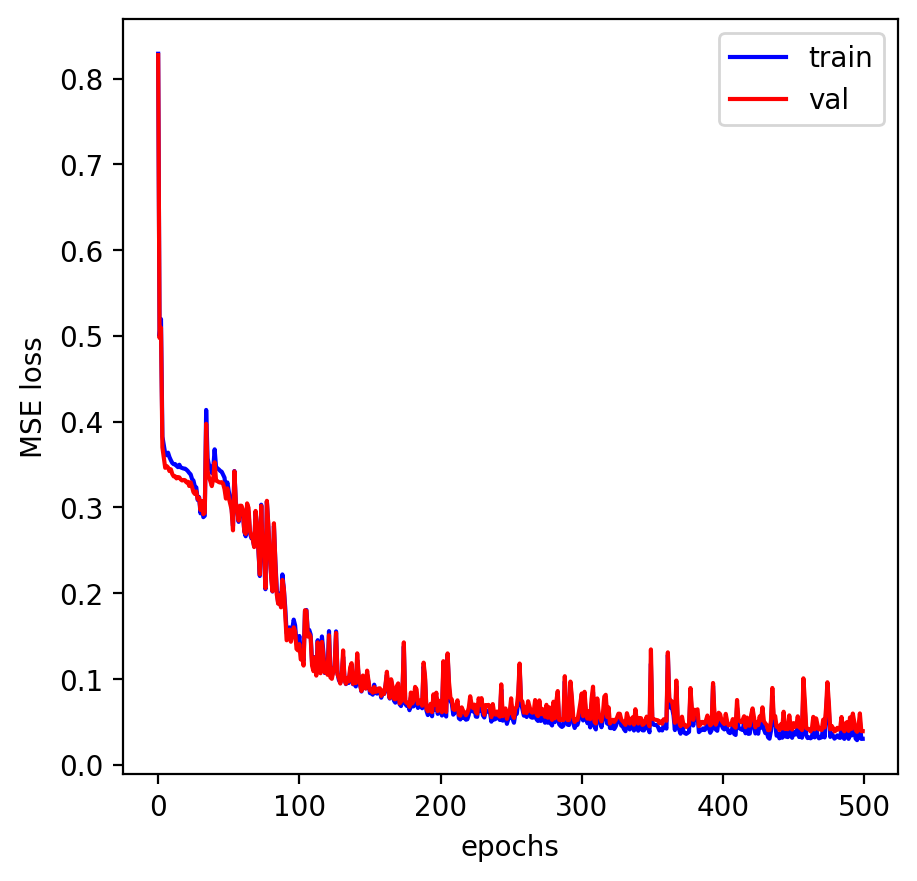

In [43]:
loss_plot(train_l1_list,val_l1_list)

In [44]:
MODEL_PATH = 'model_pyrovae_ECG_sigma_param_epochs_500_latentdim_128_better_train.pth'
torch.save(pyrovae.state_dict(), MODEL_PATH)

In [45]:
import umap.umap_ as umap

def plot_latent_pyro_vea(autoencoder, data,nei):
    stack=[]
    stacky=[]
    for i, d in enumerate(data):
        x=d['sequence']
        y=d['target'].to('cpu').detach().numpy().tolist()
        z,sigma = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        stack.extend([x for x in z])
        stacky.extend(y)
    
    umaper = umap.UMAP(n_components=2,n_neighbors=nei)
    x_umap = umaper.fit_transform(stack)
    plt.scatter(x_umap[:, 0], x_umap[:, 1],s=2, c=stacky, cmap='RdBu')
    plt.colorbar()

In [46]:
def plot_latent_pyro_vea(autoencoder, data,nei):
    stack=[]
    stacky=[]
    for i, d in enumerate(data):
        x=d['sequence']
        y=d['target'].to('cpu').detach().numpy().tolist()
        kee=[]
        for k in range(100):
            z,sigma = autoencoder.encoder(x.to(device))
            z = z.to('cpu').detach().numpy()
            kee.append([r for r in z])
        kee=np.array(kee)
        z = kee.mean(axis=0).tolist()
        stack.extend([x for x in z])
        stacky.extend(y)
    
    umaper = umap.UMAP(n_components=2,n_neighbors=nei)
    x_umap = umaper.fit_transform(stack)
    sc=plt.scatter(x_umap[:, 0], x_umap[:, 1],s=2, c=stacky, cmap='RdBu')
    cb = plt.colorbar(sc,ticks=np.arange(0,2,1))
    cb.ax.tick_params(labelsize=9)
    cb.ax.set_yticklabels(['Normal','Abnormal'])
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.show()

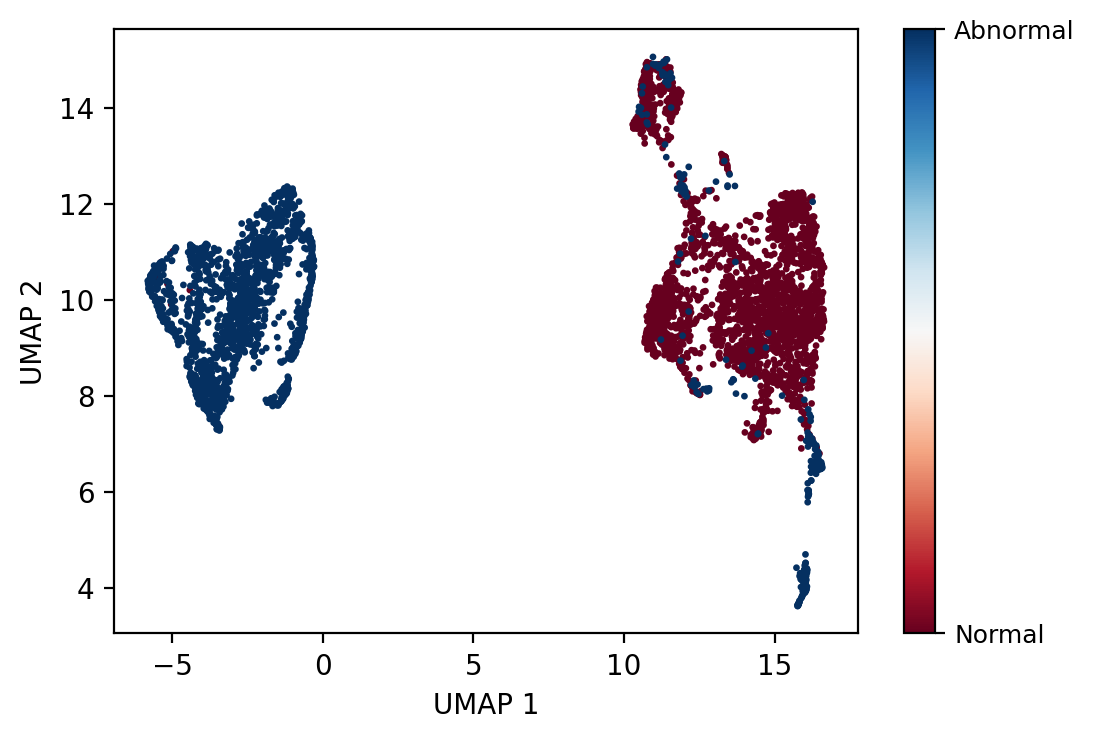

In [47]:
plot_latent_pyro_vea(pyrovae, i_data_loader,100)

To check the kind of ecg I am able to represent, for each initial ecg I am going to draw 100 representations of them 

In [48]:
rec=[]
for i in range(100):
    rec.append(pyrovae.reconstruct_ecg(torch.tensor(train_dataset[:128]).to(device)).detach().to('cpu').numpy())

In [49]:
def ecg_pred(rec,rep,i):
    ecg_sample=np.array([np.array(rec)[k].reshape(128,140,1)[i] for k in range(rep)])
    ecg_std=ecg_sample.std(axis=0)
    ecg_mean=ecg_sample.mean(axis=0)
    zeros_5=torch.tensor(ecg_sample).kthvalue(int(len(ecg_sample) * 0.05), dim=0)[0]
    zeros_95=torch.tensor(ecg_sample).kthvalue(int(len(ecg_sample) * 0.95), dim=0)[0]
    print(zeros_95.shape)
    plt.plot(np.arange(140),ecg_mean,'k',label='mean predict')
    plt.plot(np.arange(140),train_dataset[i].flatten(),'r',label='ground truth')
    plt.fill_between(np.arange(140),
                   [s[0] for s in zeros_5],
                   [s[0] for s in zeros_95],color='orange',
                   alpha=0.9,label='90% CI')
    plt.fill_between(np.arange(140),
                   [m[0]-s[0] for m,s in zip(ecg_mean,ecg_std)],
                   [m[0]+s[0] for m,s in zip(ecg_mean,ecg_std)],
                   alpha=0.5,color='blue',label='std predict')
    
    plt.legend(loc='best',fontsize=10)
    plt.xlabel('t')
    
    plt.show()

torch.Size([140, 1])


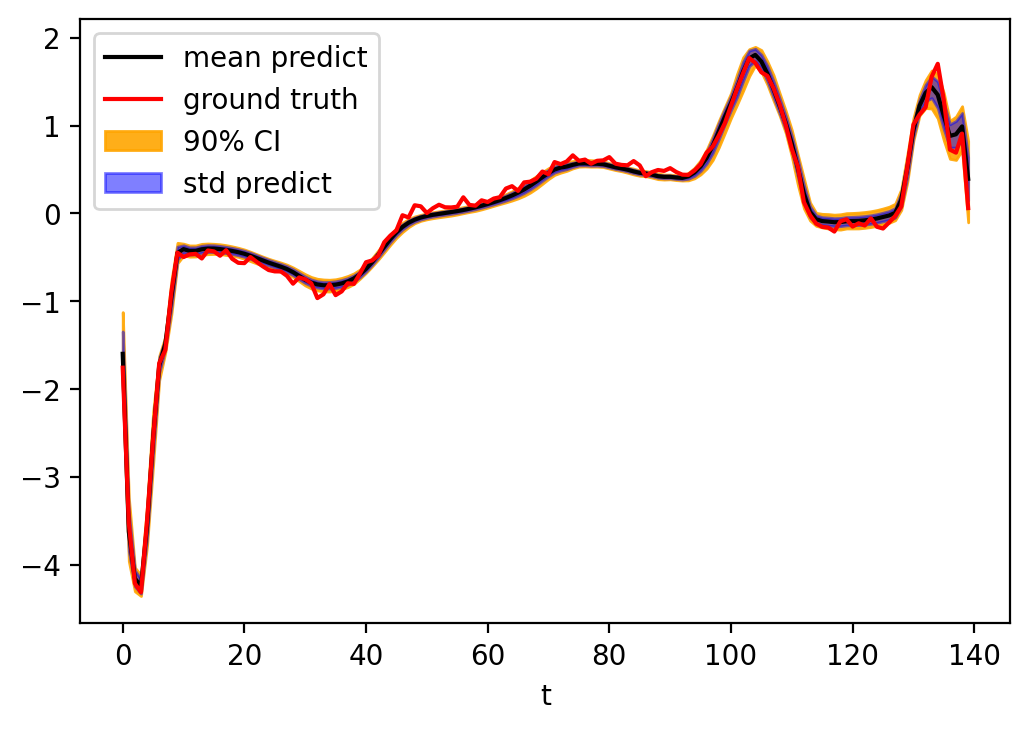

In [50]:
#ECG 11 in normal dataset
ecg_pred(rec,100,10)

torch.Size([140, 1])


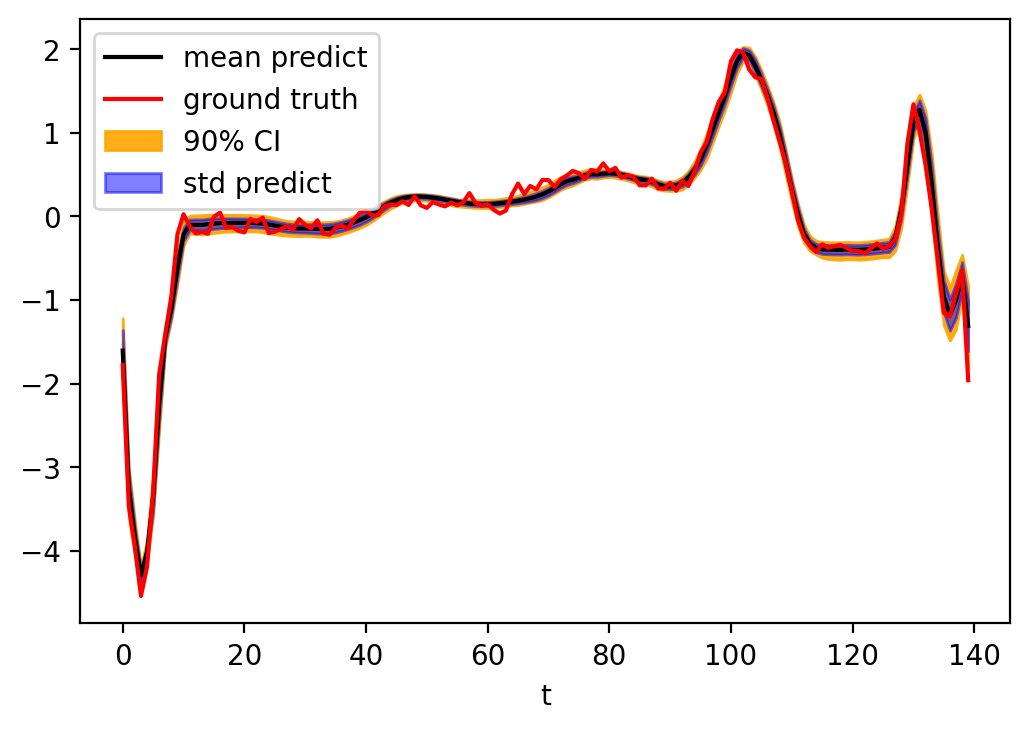

In [51]:
#ECG 51 in normal dataset
ecg_pred(rec,100,50)

In [52]:
pyro.param('sigma')

tensor([0.1859], grad_fn=<AddBackward0>)